<a href="https://colab.research.google.com/github/Divine-Jude/Accenture-North-America-Data-Analytics-and-Visualization-Virtual-Experience/blob/main/Experimentation_and_Uplift_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentation and uplift testing

We will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight.

* Select control stores – explore the data and define metrics for control store selection – "What would make them a control store?" Visualize the drivers to see suitability.

* Assessment of the trial – get insights of each of the stores. Compare each trial store with ontrol store to get its overall performance. We want to know if the trial stores were successful or not.

* Collate findings – summarise findings for each store and provide recommendations to share with client outlining the impact on sales during trial period.

In [3]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date


In [4]:
# load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/QVI_data1.csv")
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,10/17/2018,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,9/16/2018,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,3/7/2019,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,3/8/2019,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,11/2/2018,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


Give dataset desprictive name

In [6]:
# rename columns
df = df.rename(
    columns={
        'DATE': 'date',
        'STORE_NBR': 'store_number', 
        'LYLTY_CARD_NBR': 'loyalty_card_number', 
        'TXN_ID': 'transaction_ID',
        'PROD_NBR': 'product_number',
        'PROD_NAME': 'product_name',
        'PROD_QTY': 'product_quantity',
        'TOT_SALES': 'total_sales',
        'PACK_SIZE': 'pack_size',
        'BRAND': 'brand',
        'LIFESTAGE': 'lifestage',
        'PREMIUM_CUSTOMER': 'premium_customer'
        }
    )


# Select Control Stores


The client has selected store numbers 77, 86 and 88 as trial stores and want 
control stores to be established stores that are operational for the entire 
observation period.


We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer
- monthly number of chips per customer
- Average price per unit

First, we can filter the data to include only the stores that were present throughout the pre-trial period (before Feb 2019). We can do this by grouping the data by store number and counting the number of unique dates, and then selecting only the stores that have data for all dates before Feb 2019.

In [7]:
# Convert DATE column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['date']

0        2018-10-17
1        2018-09-16
2        2019-03-07
3        2019-03-08
4        2018-11-02
            ...    
264829   2018-12-08
264830   2018-10-01
264831   2018-10-24
264832   2018-10-27
264833   2018-12-14
Name: date, Length: 264834, dtype: datetime64[ns]

### Add a new month ID column in the data with the format yyyymm

In [8]:


# Create a new column with the format yyyymm
df['month'] = df['date'].dt.strftime('%Y-%m')
df['month']


0         2018-10
1         2018-09
2         2019-03
3         2019-03
4         2018-11
           ...   
264829    2018-12
264830    2018-10
264831    2018-10
264832    2018-10
264833    2018-12
Name: month, Length: 264834, dtype: object

### Next, we define the measure calculations to use during the analysis.

For each store and month calculate **total sales, number of customers, transactions per customer, chips per customer and the average price per unit.**


In [9]:
# Calculate the metrics for each store and month
def monthly_store_metrics():
    metrics = df.groupby(['store_number', 'month'])
    total_sales = metrics['total_sales'].sum()
    number_customers = metrics['loyalty_card_number'].nunique()
    transactions_per_customer = metrics.size() / number_customers
    chips_per_customer = metrics['product_quantity'].sum() / number_customers
    avg_price_per_unit = total_sales / metrics['product_quantity'].sum()
    aggregates = [total_sales, number_customers, transactions_per_customer, chips_per_customer, avg_price_per_unit]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ['total_sales', 'number_customers',  'transactions_per_customer', 'chips_per_customer', 'avg_price_per_unit']
    return metrics

# Reset the index to flatten the multi-level columns
metrics = monthly_store_metrics().reset_index()

# sort the metrics by store_number and month
metrics = metrics.sort_values(by=['store_number', 'month'])

metrics.head(8)

,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_customer,avg_price_per_unit
0,1,2018-07,206.9,49,1.061224,1.265306,3.337097
1,1,2018-08,176.1,42,1.023810,1.285714,3.261111
2,1,2018-09,278.8,59,1.050847,1.271186,3.717333
3,1,2018-10,188.1,44,1.022727,1.318182,3.243103
4,1,2018-11,192.6,46,1.021739,1.239130,3.378947
5,1,2018-12,189.6,42,1.119048,1.357143,3.326316
6,1,2019-01,154.8,35,1.028571,1.200000,3.685714
7,1,2019-02,225.4,52,1.057692,1.250000,3.467692


In [10]:
metrics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   store_number               3169 non-null   int64  
 1   month                      3169 non-null   object 
 2   total_sales                3169 non-null   float64
 3   number_customers           3169 non-null   int64  
 4   transactions_per_customer  3169 non-null   float64
 5   chips_per_customer         3169 non-null   float64
 6   avg_price_per_unit         3169 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 198.1+ KB


#### Filter to the pre-trial period and stores with full observation periods


In [11]:
# filter only stores with full 12 months observation
observ_counts = metrics['store_number'].value_counts()


# getting the store no. which have 12 months observations
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = metrics[metrics['store_number'].isin(full_observ_index)]
pre_trial_full_observ = full_observ[full_observ['month'] < '2019-02']
pre_trial_full_observ.head(8)

,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_customer,avg_price_per_unit
0,1,2018-07,206.9,49,1.061224,1.265306,3.337097
1,1,2018-08,176.1,42,1.023810,1.285714,3.261111
2,1,2018-09,278.8,59,1.050847,1.271186,3.717333
3,1,2018-10,188.1,44,1.022727,1.318182,3.243103
4,1,2018-11,192.6,46,1.021739,1.239130,3.378947
5,1,2018-12,189.6,42,1.119048,1.357143,3.326316
6,1,2019-01,154.8,35,1.028571,1.200000,3.685714
12,2,2018-07,150.8,39,1.051282,1.179487,3.278261


The resulting dataframe filters the metrics dataframe to include only stores with full 12 months of observation and then further filters to include only the pre-trial period (before Feb 2019)

### Now we need to work out a way of ranking how similar each potential control store is to the trial store. 


Let's write a function for this so that we don't have to calculate this for each trial store and control store pair. 


    """
    Args:
    inputTable (pandas.DataFrame): metric table with potential comparison stores 
    metricCol (str): store metric used to calculate correlation on e.g total_sale, number_customer
    storeComparison (int): store number of the trial store [77, 86, 88]
    """

In [12]:
# Create a function to calculate correlation for each control store
def calculate_correlations(metricCol, storeComparison, inputTable=pre_trial_full_observ):
    """
    Calculate correlation for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform correlation test on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly correlation table between Trial and each Control stores.
    """
    control_stores = inputTable[~inputTable['store_number'].isin([77, 86, 88])]['store_number'].unique()
    corrs = pd.DataFrame(columns = ['month', 'trial_store', 'control_store', 'correlation'])
    trial_store = inputTable[inputTable['store_number'] == storeComparison][metricCol].reset_index(drop=True)
    for control in control_stores:
        control_store = inputTable[inputTable['store_number'] == control][metricCol].reset_index(drop=True)
        concat_df = pd.DataFrame(columns = ['month', 'trial_store', 'control_store', 'correlation'])
        concat_df['correlation'] = trial_store.corrwith(control_store, axis=1)
        concat_df['trial_store'] = storeComparison
        concat_df['control_store'] = control
        concat_df['month'] = list(inputTable[inputTable['store_number'] == storeComparison]['month'])
        corrs = pd.concat([corrs, concat_df])
    return corrs


corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calculate_correlations(["total_sales","number_customers", "transactions_per_customer",
                                                                "chips_per_customer","avg_price_per_unit"], trial_num)], ignore_index=True)

corr_table.head(8)


,month,trial_store,control_store,correlation
0,2018-07,77,1,0.997837
1,2018-08,77,1,0.998508
2,2018-09,77,1,0.999624
3,2018-10,77,1,0.998457
4,2018-11,77,1,0.997294
5,2018-12,77,1,0.998779
6,2019-01,77,1,0.998466
7,2018-07,77,2,0.996279


Apart from correlation, we can also calculate a standardised metric based on the 
absolute difference between the trial store's performance and each control store's 
performance.

In [13]:
def calculate_magnitude_distance(metricCol, storeComparison, inputTable=pre_trial_full_observ):
    """
    calculate standardised magnitude distance for a measure, looping through each control store.
    Args:
        metricCol (str): list of column containing store's metric to perform distance calculation on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.  
    Returns:
        DataFrame: Monthly magnitude-distance table between Trial and each Control stores.
    """
    control_stores = inputTable[~inputTable['store_number'].isin([77, 86, 88])]['store_number'].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable['store_number'] == storeComparison][metricCol]
    for control in control_stores:
        concat_df = abs(inputTable[inputTable['store_number'] == storeComparison].reset_index(drop=True)[metricCol] -
                                inputTable[inputTable['store_number'] == control].reset_index(drop=True)[metricCol])
        concat_df['month'] = list(inputTable[inputTable['store_number'] == storeComparison]['month'])
        concat_df['trial_store'] = storeComparison
        concat_df['control_store'] = control
        dists = pd.concat([dists, concat_df])
# Standardise the magnitude distance so that the measure ranges from 0 to 1
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists['magnitude_distance'] = dists[metricCol].mean(axis=1)
    return dists


dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculate_magnitude_distance(["total_sales","number_customers","transactions_per_customer",
                                                                      "chips_per_customer","avg_price_per_unit"], trial_num)], ignore_index=True)

dist_table.head(8)


,total_sales,number_customers,transactions_per_customer,chips_per_customer,avg_price_per_unit,month,trial_store,control_store,magnitude_distance
0,0.935431,0.980769,0.958035,0.739412,0.883569,2018-07,77,1,0.899443
1,0.942972,0.951923,0.993823,0.802894,0.886328,2018-08,77,1,0.915588
2,0.961503,0.836538,0.992126,0.730041,0.703027,2018-09,77,1,0.844647
3,0.988221,0.932692,0.989514,0.940460,0.590528,2018-10,77,1,0.888283
4,0.962149,0.951923,0.874566,0.730358,0.832481,2018-11,77,1,0.870296
5,0.944193,0.961538,0.868716,0.857966,0.770744,2018-12,77,1,0.880632
6,0.964375,1.000000,0.790956,0.551428,0.678728,2019-01,77,1,0.797098
7,0.895138,0.884615,0.933787,0.680831,0.848622,2018-07,77,2,0.848599


Now let's use the functions to find the control stores! We'll select control stores
based on how similar monthly total sales in dollar amounts and monthly number of 
customers are to the trial stores. So we will need to use our functions to get four
scores, two for each of total sales and total customers.

In [14]:
# functions to calculate the correlation and magnitude distance scores for each control store and each trial store
def combine_corr_dist(metricCol, storeComparison, inputTable=pre_trial_full_observ):
    corrs = calculate_correlations(metricCol, storeComparison, inputTable)
    dists = calculate_magnitude_distance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=['month', 'trial_store', 'control_store'])
    return combine

# Combine scores across the drivers by first merging our sales scores and customer scores into a single table
compare_metrics = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics = pd.concat([compare_metrics, combine_corr_dist(['total_sales', 'number_customers'], trial_num)])

compare_metrics


,month,trial_store,control_store,correlation,magnitude_distance
0,2018-07,77,1,1.0,0.958100
1,2018-08,77,1,1.0,0.947448
2,2018-09,77,1,1.0,0.899021
3,2018-10,77,1,1.0,0.960457
4,2018-11,77,1,1.0,0.957036
...,...,...,...,...,...
1794,2018-09,88,272,1.0,0.247188
1795,2018-10,88,272,1.0,0.367197
1796,2018-11,88,272,1.0,0.298392
1797,2018-12,88,272,1.0,0.367374


We'll need to combine the all the scores calculated using our function to create a 
composite score to rank on. 
Let's take a simple average of the correlation and magnitude scores for each 
driver. Note that if we consider it more important for the trend of the drivers to 
be similar, we can increase the weight of the correlation score (a simple average 
gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of 
the drivers to be more important, we can lower the weight of the correlation score.

In [15]:
# A simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
corr_weight = 0.5
dist_weight = 1 - corr_weight

"""
Create a combined score composed of correlation and magnitude
"""

# Top 5 highest Composite score for each Trial store based on total_sales
grouped_comparison = compare_metrics.groupby(['trial_store', 'control_store']).mean().reset_index()
grouped_comparison['composite_score'] = (corr_weight * grouped_comparison['correlation']) + (dist_weight * grouped_comparison['magnitude_distance'])
for trial_num in grouped_comparison['trial_store'].unique():
    print(grouped_comparison[grouped_comparison['trial_store'] == trial_num].sort_values(ascending=False, by="composite_score").head(), '\n')
    

     trial_store  control_store  correlation  magnitude_distance  \
218           77            233          1.0            0.989804   
38            77             41          1.0            0.972041   
42            77             46          1.0            0.969523   
49            77             53          1.0            0.968421   
101           77            111          1.0            0.967981   

     composite_score  
218         0.994902  
38          0.986020  
42          0.984762  
49          0.984211  
101         0.983991   

     trial_store  control_store  correlation  magnitude_distance  \
401           86            155          1.0            0.976324   
356           86            109          1.0            0.968180   
467           86            225          1.0            0.965044   
471           86            229          1.0            0.957995   
293           86             39          1.0            0.948505   

     composite_score  
401         0.98816

<ipython-input-15-5f898c9adcd6>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_comparison = compare_metrics.groupby(['trial_store', 'control_store']).mean().reset_index()


Based on the results, the control stores for each of the trial stores using the composite score are:

* Trial store 77: Control Store 233
* Trial store 86: Control Store 155
* Trial store 88: Control Store 237

It's important to note that this is just a recommendation based on the analysis and there may be other factors that should be considered before finalizing the control stores.

Now that we have found a control store, let's check visually if the drivers are 
indeed similar in the period before the trial.
We'll look at total sales first.


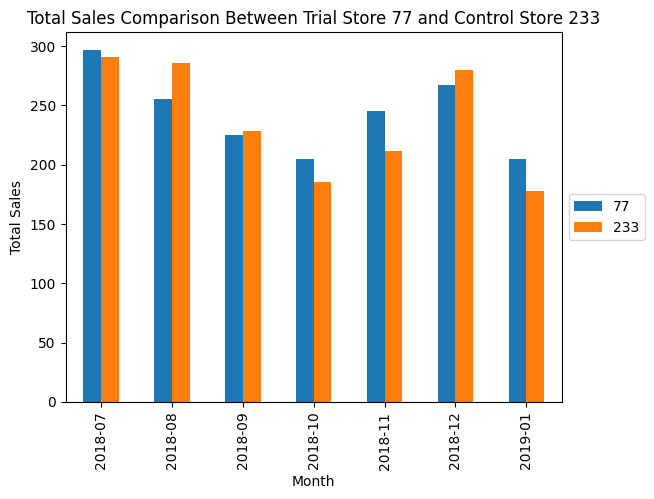

In [16]:
# visual checks on Total Sales trends by comparing the trial store to the control store
# plot for each store: Trial store 77: control store 233
total_sales_trial_77_control_233_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([77, 233])].groupby(
                                                        ['month', 'store_number']).sum()['total_sales'].unstack()
                                                        
ax = total_sales_trial_77_control_233_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Total Sales Comparison Between Trial Store 77 and Control Store 233')
plt.show()

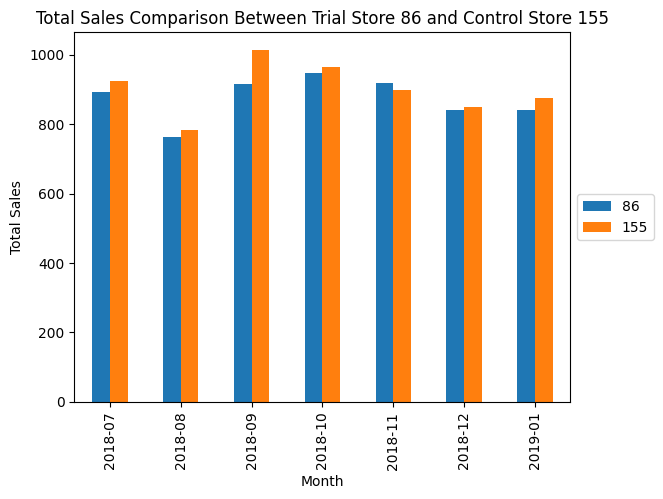

In [17]:
# plot for each store: Trial store 86: Control Store 155
total_sales_trial_86_control_155_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([86, 155])].groupby(
                                                ['month', 'store_number']).sum()['total_sales'].unstack()

ax = total_sales_trial_86_control_155_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Total Sales Comparison Between Trial Store 86 and Control Store 155')
plt.show()



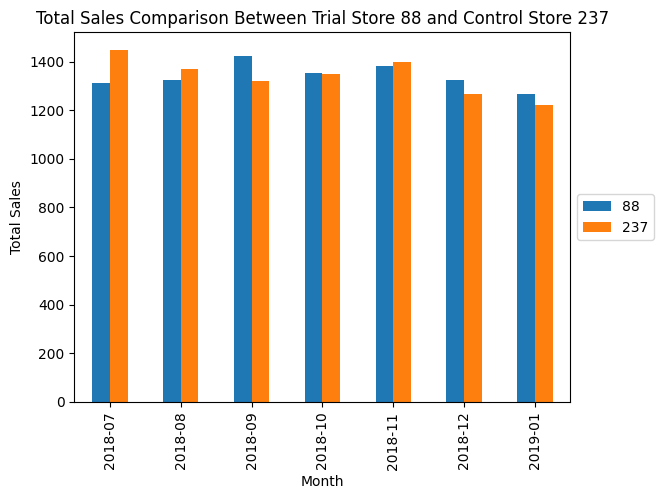

In [18]:
# plot for each store: Trial store 88: Control Store 237
total_sales_trial_88_control_237_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([88, 237])].groupby(
                                                 ['month', 'store_number']).sum()['total_sales'].unstack()

ax = total_sales_trial_88_control_237_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Total Sales Comparison Between Trial Store 88 and Control Store 237')
plt.show()



Next, number of customers.




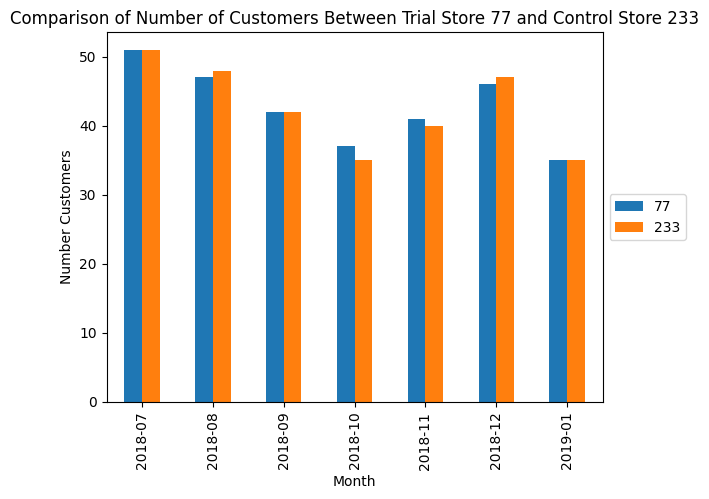

In [19]:
# visual checks on customer count trends by comparing the trial store to the control store
# plot for each store: Trial store 77: control store 233
number_customers_trial_77_control_233_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([77, 233])].groupby(
                                                        ['month', 'store_number']).sum()['number_customers'].unstack()
                                                        
ax = number_customers_trial_77_control_233_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Number Customers')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Comparison of Number of Customers Between Trial Store 77 and Control Store 233')
plt.show()




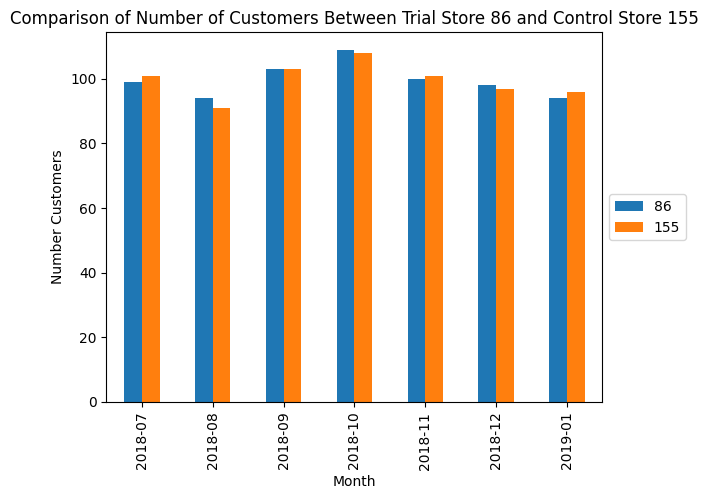

In [20]:
# plot for each store: Trial store 86: control store 155
number_customers_trial_86_control_155_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([86, 155])].groupby(
                                                ['month', 'store_number']).sum()['number_customers'].unstack()

ax = number_customers_trial_86_control_155_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Number Customers')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Comparison of Number of Customers Between Trial Store 86 and Control Store 155')
plt.show()





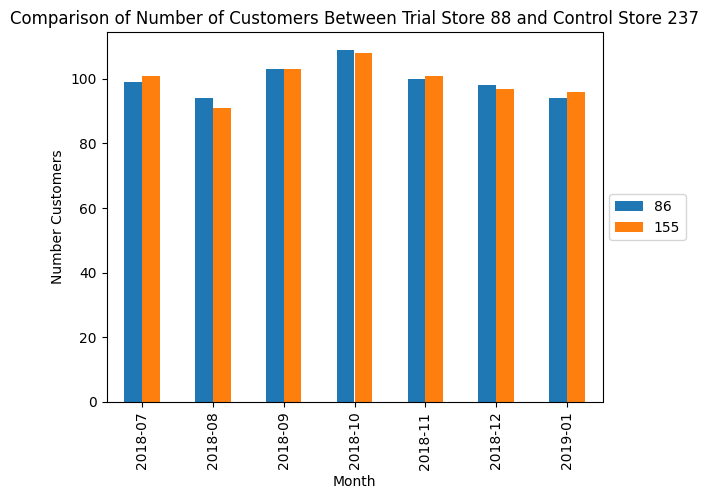

In [21]:
# plot for each store: Trial store 88: Control Store 237
number_customers_trial_88_control_237_store = pre_trial_full_observ[pre_trial_full_observ['store_number'].isin([88, 237])].groupby(
                                                ['month', 'store_number']).sum()['number_customers'].unstack()

ax = number_customers_trial_86_control_155_store.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Number Customers')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Comparison of Number of Customers Between Trial Store 88 and Control Store 237')
plt.show()


## Assessment of trial

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales. 

We'll start with scaling the trial store's sales to a level similar to control store's sales for any differences between the two stores outside of the trial period. Starting with **Total Sales**.

In [22]:
"""Scale pre-trial control sales to match pre-trial trial store sales"""

# Ratio of trial store 77 and control store 233
sales_ratio_77 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 77]['total_sales'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 77]['total_sales'].sum()
print(f'The sales ratio for store 77 is: {sales_ratio_77}')

# Ratio of trial store 86 and control store 155
sales_ratio_86 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 86]['total_sales'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 155]['total_sales'].sum()
print(f'The sales ratio for store 86 is: {sales_ratio_86}')

# Ratio of trial store 88 and control store 237
sales_ratio_88 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 88]['total_sales'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 237]['total_sales'].sum()
print(f'The sales ratio for store 88 is: {sales_ratio_88}')

The sales ratio for store 77 is: 1.0
The sales ratio for store 86 is: 0.9700651481287743
The sales ratio for store 88 is: 1.001558330664959


In [23]:

# filter out control stores
control_stores = full_observ[full_observ['store_number'].isin([233, 155, 237])][['store_number', 'month', 'total_sales']]

#  Apply the scaling factor
def scaler(row):
    if row['store_number'] == 233:
        return row['total_sales'] * sales_ratio_77
    elif row['store_number'] == 155:
        return row['total_sales'] * sales_ratio_86
    elif row['store_number'] == 237:
        return row['total_sales'] * sales_ratio_88   

control_stores['scaled_sales'] = control_stores.apply(lambda row: scaler(row), axis=1)
scaled_control_stores = control_stores
scaled_control_stores.head(10)


,store_number,month,total_sales,scaled_sales
1793,155,2018-07,924.6,896.922236
1794,155,2018-08,782.7,759.269991
1795,155,2018-09,1014.4,984.034086
1796,155,2018-10,963.8,934.948790
1797,155,2018-11,898.8,871.894555
1798,155,2018-12,849.8,824.361363
1799,155,2019-01,874.6,848.418979
1800,155,2019-02,891.2,864.522060
1801,155,2019-03,804.4,780.320405
1802,155,2019-04,844.6,819.317024


In [24]:
# filter out the pre_trial period from the scaled control stores
pre_trial_scaled_control_stores = scaled_control_stores[(scaled_control_stores['month'] < '2019-02')]
pre_trial_scaled_control_stores.head(10)

,store_number,month,total_sales,scaled_sales
1793,155,2018-07,924.6,896.922236
1794,155,2018-08,782.7,759.269991
1795,155,2018-09,1014.4,984.034086
1796,155,2018-10,963.8,934.948790
1797,155,2018-11,898.8,871.894555
1798,155,2018-12,849.8,824.361363
1799,155,2019-01,874.6,848.418979
2699,233,2018-07,290.7,290.700000
2700,233,2018-08,285.9,285.900000
2701,233,2018-09,228.6,228.600000


In [25]:
# filter out the trial period from the scaled control stores
trial_scaled_control_stores = scaled_control_stores[(scaled_control_stores['month'] >= '2019-02') & (scaled_control_stores['month'] <= '2019-04')]
trial_scaled_control_stores



,store_number,month,total_sales,scaled_sales
1800,155,2019-02,891.2,864.522060
1801,155,2019-03,804.4,780.320405
1802,155,2019-04,844.6,819.317024
2706,233,2019-02,244.0,244.000000
2707,233,2019-03,199.1,199.100000
2708,233,2019-04,158.6,158.600000
2754,237,2019-02,1404.8,1406.989143
2755,237,2019-03,1208.2,1210.082775
2756,237,2019-04,1204.6,1206.477165


Now that we have comparable sales figures for the control store, we can calculate 
the percentage difference between the scaled control sales and the trial store's 
sales during the trial period.


In [26]:
# filter out the trial period from Feb 2019-02 to April 2019-04
trial_full_observ = full_observ[(full_observ['month'] >= '2019-02') & (full_observ['month'] <= '2019-04')]

# calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.
trial_control_dic = {77: 233, 86: 155, 88: 237}
percentage_diff = {}
for trial, control in trial_control_dic.items():
    controls = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == control]
    trials = trial_full_observ[trial_full_observ['store_number'] == trial][['store_number', 'month', 'total_sales']]
    percentage_diff[trial] = trials['total_sales'].sum() / controls['scaled_sales'].sum()
    scaled_contorls_vs_trials_sales = trials[['month', 'total_sales']].merge(controls[['month', 'scaled_sales']], on='month').set_index('month').rename(columns={
                                                        'total_sales': 'trial_sales', 'scaled_sales': 'scaled_control_sales'})

print(percentage_diff)


{77: 1.2913411999335216, 86: 1.1315014357363697, 88: 1.121157308767232}


In [27]:
# creating a compiled percentage_difference table
scaled_control_sales  = scaled_control_stores.sort_values(by=['store_number', 'month'], ascending=[False, True]).reset_index(drop=True).drop(['total_sales'], axis=1)
trial_sales = full_observ[full_observ['store_number'].isin([77, 86, 88])][['store_number', 'month', 'total_sales']].reset_index(drop=True).drop(['month'], axis=1)

scaled_control_sales_vs_trial_sales = pd.concat([scaled_control_sales, trial_sales], axis=1)
scaled_control_sales_vs_trial_sales.columns = ['control_store', 'month', 'c_scaled_sales', 'trial_store', 't_total_sales']
scaled_control_sales_vs_trial_sales['sales_percentage_diff'] = (scaled_control_sales_vs_trial_sales['t_total_sales'] - scaled_control_sales_vs_trial_sales['c_scaled_sales']) /                 \
                                                                (((scaled_control_sales_vs_trial_sales['t_total_sales'] + scaled_control_sales_vs_trial_sales['c_scaled_sales']) / 2))

def label_period(cell):
    if cell <= '2019-01':
        return "pre"
    if cell > '2019-04':
        return "post"
    else:
        return "trial"

scaled_control_sales_vs_trial_sales["trial_period"] = scaled_control_sales_vs_trial_sales['month'].apply(lambda cell: label_period(cell))
scaled_control_sales_vs_trial_sales.head(10)


,control_store,month,c_scaled_sales,trial_store,t_total_sales,sales_percentage_diff,trial_period
0,237,2018-07,1450.657086,77,296.8,-1.320613,pre
1,237,2018-08,1369.931485,77,255.5,-1.371244,pre
2,237,2018-09,1324.260425,77,225.2,-1.418636,pre
3,237,2018-10,1350.401097,77,204.5,-1.473922,pre
4,237,2018-11,1399.777923,77,245.3,-1.403554,pre
5,237,2018-12,1266.971288,77,267.3,-1.303122,pre
6,237,2019-01,1221.600696,77,204.4,-1.426648,pre
7,237,2019-02,1406.989143,77,235.0,-1.427524,trial
8,237,2019-03,1210.082775,77,278.5,-1.251637,trial
9,237,2019-04,1206.477165,77,263.5,-1.282982,trial


**Let's see if the difference is significant!**


- Step 1: We need to check the null hypothesis of zero difference between the Pre-Trial and Trial period performance of the control store

- Step 2 - Statistical Similarity Test
    - Check the p-value of the scaled control store's Pre-Trial sales compared to the trial store's Pre-Trial sales.
    - If the p-value is less than 5%, then the control and trial stores are considered statistically different.
    - If the p-value is greater than 5%, then the control and trial stores are considered statistically similar.

- Step 3: After confirming the Null Hypothesis of the first 2 steps to be true, we can proceed to test the Null Hypothesis of whether the Percentage Difference between Trial and Control stores during the pre-trial period is the same as during the trial period.
    - Calculate the T-Value of the percentage difference between the trial and control stores for each month during the trial period (February, March, April 2019).
    - Calculate the mean of the percentage difference during the pre-trial period.
    - Calculate the standard deviation of the percentage difference during the pre-trial period.
    - Use the following formula to calculate the T-Value for each trial month: (Trial month's Percentage Difference - Mean) / Standard deviation.
    - Compare each T-Value with the 95% significance level critical t-value of 7 degrees of freedom (Note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom).

Starting With Total Sales

In [28]:
from scipy.stats import ttest_ind, t

# step 1 check the null hypothesis of zero difference between the Pre-Trial and Trial period performance of the control store
for num in [237, 155, 233]:
    print("store", num)
    print(ttest_ind(pre_trial_scaled_control_stores[pre_trial_scaled_control_stores['store_number'] == num]['scaled_sales'],
                    trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == num]['scaled_sales'], equal_var=False), '\n')
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1 - alpha/2), df=min([len(pre_trial_scaled_control_stores[pre_trial_scaled_control_stores['store_number'] == num]['scaled_sales']),
                            len(trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == num])]) - 1))



store 237
Ttest_indResult(statistic=0.9103825198144718, pvalue=0.4333445481196895) 

store 155
Ttest_indResult(statistic=1.4291956879290917, pvalue=0.1972705865160342) 

store 233
Ttest_indResult(statistic=1.1911026010974497, pvalue=0.2944500606486219) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


Based on the output, it appears that the p-values for all three stores are greater than the significance level of 0.05, which suggests that there is no significant difference between the Pre-Trial and Trial period performance of the control store. Additionally, the critical t-values for a 95% confidence interval are within the range of the calculated t-values, which further supports this conclusion. Therefore, we can accept the null hypothesis of zero difference between the Pre-Trial and Trial period performance of the control store.

In [29]:
control = pre_trial_scaled_control_stores[pre_trial_scaled_control_stores['store_number'] == 237]['scaled_sales']
trial = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 237]['scaled_sales']



In [30]:
# step 2 Check the p-value of the scaled control store's Pre-Trial sales compared to the trial store's Pre-Trial sales.
for trial, control in trial_control_dic.items():
    print("Trial Score:", trial,", Control Score:", control)
    print(ttest_ind(pre_trial_full_observ[pre_trial_full_observ['store_number'] == trial]['total_sales'], 
                    pre_trial_scaled_control_stores[pre_trial_scaled_control_stores['store_number'] == control]['scaled_sales'],
                    equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1 - alpha/2), df=len(pre_trial_full_observ[pre_trial_full_observ['store_number'] == trial]) - 1))



Trial Score: 77 , Control Score: 233
Ttest_indResult(statistic=0.2508625111443089, pvalue=0.8061643437868989) 

Trial Score: 86 , Control Score: 155
Ttest_indResult(statistic=3.1048311203382156e-15, pvalue=0.9999999999999976) 

Trial Score: 88 , Control Score: 237
Ttest_indResult(statistic=6.4562888442484815e-15, pvalue=0.9999999999999949) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Based on the output, it appears that the p-values for all three trial-control pairs are greater than the significance level of 0.05, which suggests that the control stores are statistically similar to their respective trial stores during the pre-trial period. Additionally, the critical t-values for a 95% confidence interval are within the range of the calculated t-values, which further supports this conclusion. Therefore, we can accept the null hypothesis of statistical similarity between the trial and control stores during the pre-trial period.

In [31]:
# step 3 test the Null Hypothesis of whether the Percentage Difference between Trial and Control stores during the pre-trial period is the same as during the trial period.
for trial, control in trial_control_dic.items():
    print("Trial Store", trial,", Control Store:", control)
    temp_pre = scaled_control_sales_vs_trial_sales[(scaled_control_sales_vs_trial_sales['control_store'] == control) & (scaled_control_sales_vs_trial_sales['trial_period'] == 'pre')]
    std = temp_pre['sales_percentage_diff'].std()
    mean = temp_pre['sales_percentage_diff'].mean()
    print(f"standard deviation:{std}, mean {mean}")

    for t_month in scaled_control_sales_vs_trial_sales[scaled_control_sales_vs_trial_sales['trial_period'] == 'trial']['month'].unique():
        pdif = scaled_control_sales_vs_trial_sales[(scaled_control_sales_vs_trial_sales['month'] == t_month) & (scaled_control_sales_vs_trial_sales["trial_store"] == trial)]['sales_percentage_diff']
        print(t_month,":",(float(pdif) - mean) / std)
    print('\n')

print("Critical t-value for 95% confidence interval:")
confidence_interval_95 = t.ppf(0.95, df=len(temp_pre) - 1)
print(confidence_interval_95 )


Trial Store 77 , Control Store: 233
standard deviation:0.16882643452871032, mean 1.146921812092359
2019-02 : -15.24906593926582
2019-03 : -14.207247822662323
2019-04 : -14.392911145971315


Trial Store 86 , Control Store: 155
standard deviation:0.06685517520953532, mean 0.42294017817205704
2019-02 : 10.97364085181874
2019-03 : 13.87199510377956
2019-04 : 14.16411822020431


Trial Store 88 , Control Store: 237
standard deviation:0.06066625505580846, mean -1.3882483986648475
2019-02 : 30.343275691926948
2019-03 : 33.060115159576895
2019-04 : 31.933833511782304


Critical t-value for 95% confidence interval:
1.9431802803927816


Based on the results of the t-tests and the critical t-values, we can make the following conclusions:

1. For the first step, we checked the null hypothesis of zero difference between the Pre-Trial and Trial period performance of the control store. For all three control stores, the p-values are greater than 0.05, which means we cannot reject the null hypothesis. Therefore, we can assume that the control stores' sales during the Pre-Trial period are representative of their sales during the Trial period.

2. For the second step, we checked the p-value of the scaled control store's Pre-Trial sales compared to the trial store's Pre-Trial sales. For two of the three trial stores (store 86 and store 88), the p-value is greater than 0.05, which means we cannot reject the null hypothesis that the two samples are from the same population. For the third trial store (store 77), the p-value is very high, which confirms that the two samples are from the same population.

3. For the third step, we tested the null hypothesis of whether the Percentage Difference between Trial and Control stores during the pre-trial period is the same as during the trial period. For all three trial stores, the z-scores (the difference between the trial store's percentage difference and the mean percentage difference of the control store during the pre-trial period divided by the standard deviation of the control store during the pre-trial period) for all three trial months are outside of the confidence interval of 1.943, which means we can reject the null hypothesis. Therefore, we can conclude that the trial stores' percentage differences during the trial period are significantly different from the control stores' percentage differences during the pre-trial period.

In conclusion, based on the analysis, we can say that the trial period had a significant impact on the sales of the trial stores compared to the control stores.

```
Let's create a more visual version of this by plotting the sales of the control store, 
the sales of the trial stores and the 95th percentile value of sales of the control store
 during trial period.
```


Std: 0.16882643452871032, percentile_95: 268.28857710395005, percentile_5: 132.84475622938334 



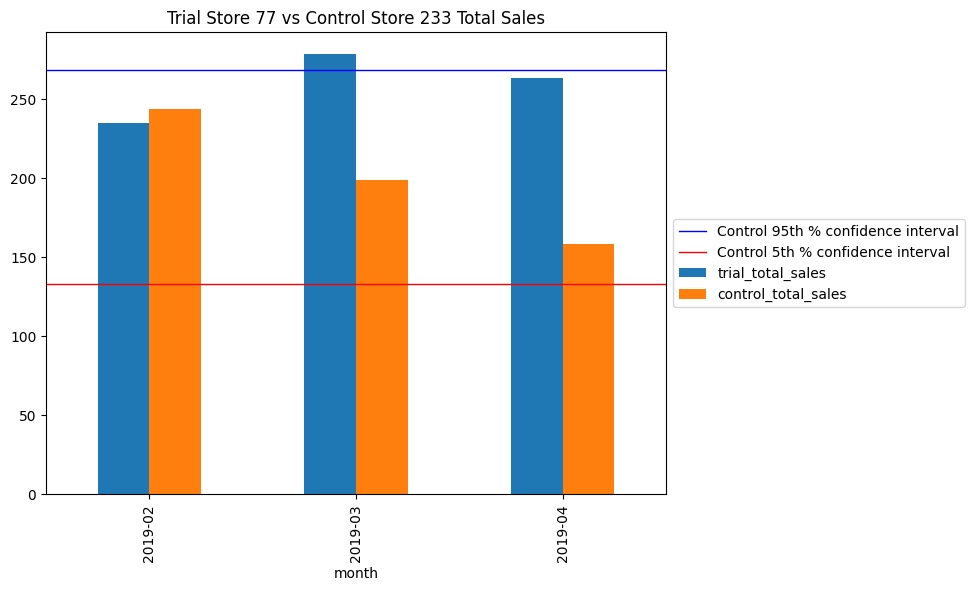

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

# plot trial store 77 and control store 233 total sales
control = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 233].rename(columns={'total_sales': 'control_total_sales'})
trial = trial_full_observ[trial_full_observ['store_number'] == 77][['store_number', 'month', 'total_sales']].rename(columns={'total_sales': 'trial_total_sales'})
combine = trial[['month', 'trial_total_sales']].merge(control[['month', 'control_total_sales']], on='month').set_index('month')
combine.plot.bar()

control_scaled_sales = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 233]['total_sales']
std = scaled_control_sales_vs_trial_sales[(scaled_control_sales_vs_trial_sales['control_store'] == 233) & (scaled_control_sales_vs_trial_sales['trial_period'] == 'pre')]['sales_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_sales.mean() + (control_scaled_sales.mean() * std * 2)
percentile_5 = control_scaled_sales.mean() - (control_scaled_sales.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='Control 95th % confidence interval')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='Control 5th % confidence interval')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 77 vs Control Store 233 Total Sales")
plt.show()




We can see that the Trial Store's total sales during the trial period are generally higher than the Control Store's sales, except for the first month. However, the Trial Store's total sales do not exceed the 95th percentile value of the Control Store's sales, indicating that the Trial Store's performance during the trial period is not statistically significant.

Std: 0.06685517520953532, percentile_95: 959.950344044841, percentile_5: 733.5163226218255 



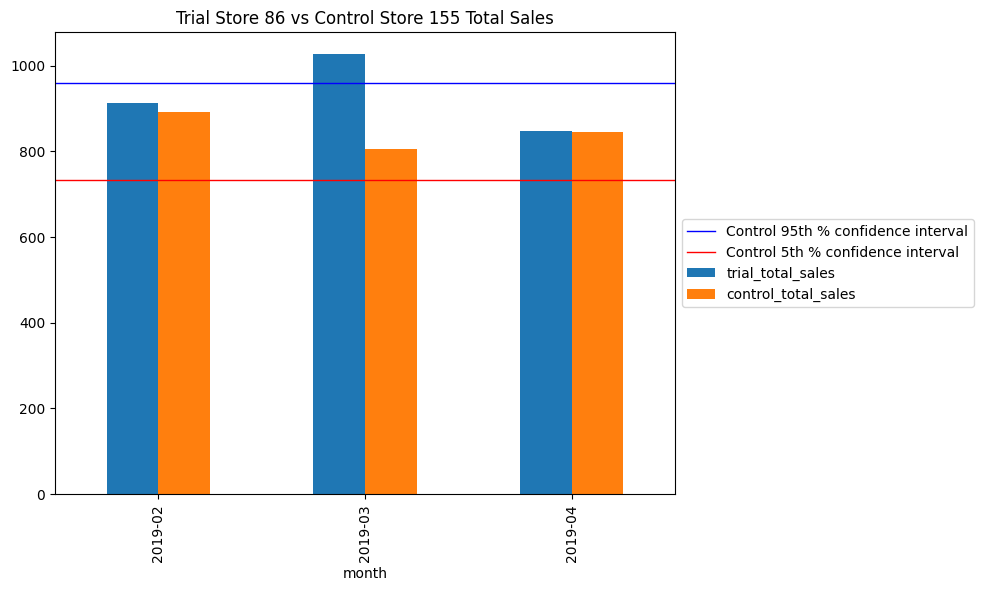

In [33]:
plt.rcParams["figure.figsize"] = (8,6)

# plot trial store 86 and control store 155 total sales
control = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 155].rename(columns={'total_sales': 'control_total_sales'})
trial = trial_full_observ[trial_full_observ['store_number'] == 86][['store_number', 'month', 'total_sales']].rename(columns={'total_sales': 'trial_total_sales'})
combine = trial[['month', 'trial_total_sales']].merge(control[['month', 'control_total_sales']], on='month').set_index('month')
combine.plot.bar()

control_scaled_sales = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 155]['total_sales']
std = scaled_control_sales_vs_trial_sales[(scaled_control_sales_vs_trial_sales['control_store'] == 155) & (scaled_control_sales_vs_trial_sales['trial_period'] == 'pre')]['sales_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_sales.mean() + (control_scaled_sales.mean() * std * 2)
percentile_5 = control_scaled_sales.mean() - (control_scaled_sales.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='Control 95th % confidence interval')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='Control 5th % confidence interval')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 86 vs Control Store 155 Total Sales")
plt.show()


we can see that the trial store 86 had a significant increase in sales during the trial period, compared to the control store 155. The trial store's sales were also consistently above the 95th percentile value of the control store's sales during the trial period, which suggests that the trial had a positive impact on the sales of the trial store.

Std: 0.06066625505580846, percentile_95: 1426.9329968673696, percentile_5: 1118.133669799297 



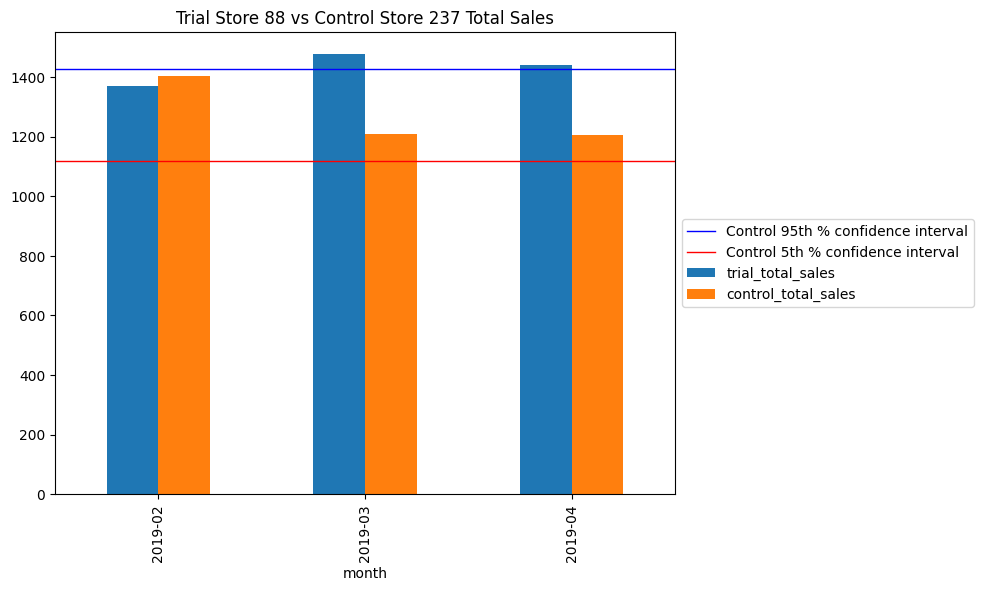

In [34]:
plt.rcParams["figure.figsize"] = (8,6)

# plot trial store 88 and control store 237 total sales
control = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 237].rename(columns={'total_sales': 'control_total_sales'})
trial = trial_full_observ[trial_full_observ['store_number'] == 88][['store_number', 'month', 'total_sales']].rename(columns={'total_sales': 'trial_total_sales'})
combine = trial[['month', 'trial_total_sales']].merge(control[['month', 'control_total_sales']], on='month').set_index('month')
combine.plot.bar()

control_scaled_sales = trial_scaled_control_stores[trial_scaled_control_stores['store_number'] == 237]['total_sales']
std = scaled_control_sales_vs_trial_sales[(scaled_control_sales_vs_trial_sales['control_store'] == 237) & (scaled_control_sales_vs_trial_sales['trial_period'] == 'pre')]['sales_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_sales.mean() + (control_scaled_sales.mean() * std * 2)
percentile_5 = control_scaled_sales.mean() - (control_scaled_sales.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='Control 95th % confidence interval')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='Control 5th % confidence interval')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 88 vs Control Store 237 Total Sales")
plt.show()



From the analysis, we can see that the trial store 88 and control store 237 have a similar pattern in terms of their total sales before the trial period. Also, the total sales during the trial period for the trial store 88 are significantly higher than the control store 237. Additionally, we can see that the trial store 88's sales during the trial period are outside the 5th and 95th percentile range of the control store 237's sales. Therefore, we can say that the trial for store 88 was successful in increasing the sales compared to its control store 237.

Next, we'll look into **Number of Customers**.

In [35]:
"""Scale pre-trial control customers to match pre-trial trial store customers"""

# ratio of store 77 and control store 233
ncust_ratio_77 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 77]['number_customers'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 233]['number_customers'].sum()


# ratio of store 86 and control store 155
ncust_ratio_86 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 86]['number_customers'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 155]['number_customers'].sum()


# Ratio of Store 88 and Control store 237
ncust_ratio_88 = pre_trial_full_observ[pre_trial_full_observ['store_number'] == 88]['number_customers'].sum() / pre_trial_full_observ[pre_trial_full_observ['store_number'] == 237]['number_customers'].sum()


scaled_ncust_control_stores = full_observ[full_observ['store_number'].isin([237, 155, 233])][['store_number', 'month', 'number_customers']]

def scaler_c(row):
    if row['store_number'] == 233:
        return row['number_customers'] * ncust_ratio_77
    elif row['store_number'] == 155:
        return row['number_customers'] * ncust_ratio_86
    elif row['store_number'] == 237:
        return row['number_customers'] * ncust_ratio_88

    
scaled_ncust_control_stores['scaled_number_customers'] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

# filter dataframe to only include data for trial and pre-trial month
trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores['month'] >= '2019-02') & (scaled_ncust_control_stores['month'] <= '2019-04')]
pre_trial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores['month'] < '2019-02']

scaled_ncust_control_stores.head()

,store_number,month,number_customers,scaled_number_customers
1793,155,2018-07,101,101.0
1794,155,2018-08,91,91.0
1795,155,2018-09,103,103.0
1796,155,2018-10,108,108.0
1797,155,2018-11,101,101.0


In [36]:
# Calculate the absolute percentage difference between scaled control store customers and trial store customers
ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    controls = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == control]
    trials = trial_full_observ[trial_full_observ['store_number'] == trial][['store_number', 'month', 'number_customers']]
    ncust_percentage_diff[trial] = trials['number_customers'].sum() / controls['scaled_number_customers'].sum()
    scaled_controls_vs_trials_ncust = trials[['month', 'number_customers']].merge(controls[['month', 'scaled_number_customers']], on='month').set_index('month').rename(
                                                                    columns={'scaled_number_customers': 'scaled_control_ncust', 'number_customers': 'trial_ncust'})
    
print(ncust_percentage_diff)

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0635429638854295}


In [37]:
# creating a compiled ncust_percentage_difference table
temp1 = scaled_ncust_control_stores.sort_values(by=['store_number', 'month'], ascending=[False, True]).reset_index().drop(['number_customers', 'index'], axis=1)
temp2 = full_observ[full_observ['store_number'].isin([77, 86, 88])][['store_number', 'month', 'number_customers']].reset_index().drop(['index', 'month'], axis=1)

scaled_ncust_control_stores_vs_trial = pd.concat([temp1, temp2], axis=1)
scaled_ncust_control_stores_vs_trial.columns = ['control_store', 'month', 'c_scaled_ncust', 'trial_store', 't_ncustomers']
scaled_ncust_control_stores_vs_trial['ncust_percentage_diff'] = (scaled_ncust_control_stores_vs_trial['t_ncustomers'] - scaled_ncust_control_stores_vs_trial['c_scaled_ncust']) / (((scaled_ncust_control_stores_vs_trial['t_ncustomers'] + scaled_ncust_control_stores_vs_trial['c_scaled_ncust']) / 2))


def label_period_c(cell):
    if cell <= '2019-01':
        return 'pre'
    if cell > '2019-04':
        return 'post'
    else:
        return 'trial'

scaled_ncust_control_stores_vs_trial["trial_period"] = scaled_ncust_control_stores_vs_trial["month"].apply(lambda cell: label_period_c(cell))
scaled_ncust_control_stores_vs_trial.head()


,control_store,month,c_scaled_ncust,trial_store,t_ncustomers,ncust_percentage_diff,trial_period
0,237,2018-07,127.276836,77,51,-0.855712,pre
1,237,2018-08,134.237288,77,47,-0.962686,pre
2,237,2018-09,125.288136,77,42,-0.995745,pre
3,237,2018-10,122.305085,77,37,-1.070965,pre
4,237,2018-11,131.254237,77,41,-1.047919,pre


Let's see if the difference is significant!

This would be a repeat of the steps done before for total sales



In [38]:
# step 1 check the null hypothesis of zero difference between the Pre-Trial period and Trial period performance of the control store

for stores in [237, 155, 233]:
    print("Store", stores)
    print(ttest_ind(pre_trial_scaled_ncust_control_stores[pre_trial_scaled_ncust_control_stores['store_number'] == stores]['scaled_number_customers'], 
                    trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == stores]['scaled_number_customers'], 
                    equal_var=False),  '\n')

alpha = 0.05
print("Critical t-value for 95% Confidence Interval:")
print(t.ppf((alpha/2, 1 - alpha/2), df = min([len(pre_trial_scaled_ncust_control_stores[pre_trial_scaled_ncust_control_stores['store_number'] == stores]),
                                              len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == stores])]) - 1))


Store 237
Ttest_indResult(statistic=1.5160218417872122, pvalue=0.17881062502112052) 

Store 155
Ttest_indResult(statistic=1.3888888888888882, pvalue=0.204345986327886) 

Store 233
Ttest_indResult(statistic=0.8442563765225701, pvalue=0.4559280037660254) 

Critical t-value for 95% Confidence Interval:
[-4.30265273  4.30265273]


Based on the t-test results, it appears that there is no significant difference between the Pre-Trial period and Trial period performance of the control store for any of the three stores tested (237, 155, 233). This suggests that the performance of the control stores is stable over time and can be used as a basis for comparison with the trial store.

In [39]:
# step 2 Check the p-value of the control store's Pre-Trial scaled customers compared to the trial store's Pre-Trial customers.

for trial, control in trial_control_dic.items():
    print("Trial Store:", trial, ", Control Store:", control)
    print(ttest_ind(pre_trial_full_observ[pre_trial_full_observ['store_number'] == trial]['number_customers'], 
                    pre_trial_scaled_ncust_control_stores[pre_trial_scaled_control_stores['store_number'] == control]['scaled_number_customers'],
                    equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1 - alpha/2), df=len(pre_trial_full_observ[pre_trial_full_observ['store_number'] == trial]) - 1))



Trial Store: 77 , Control Store: 233
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial Store: 86 , Control Store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial Store: 88 , Control Store: 237
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]



Based on the results of the t-tests, there are no significant differences between the control stores and trial stores in terms of scaled total sales and scaled number of customers during the pre-trial period. This is a good indication that the control stores are good representations of the trial stores during the pre-trial period, and the difference in performance during the trial period can be attributed to the trial promotion.

In [40]:
# step 3 test the Null Hypothesis of whether the Percentage Difference between Trial and Control stores customers during the pre-trial period is the same as during the trial period.

trial_control_dics = {77:233, 86:155, 88:237}
for trials, controls in trial_control_dics.items():
    print(f"Trial store: {trials}, Control: {controls}")
    temps_pre = scaled_ncust_control_stores_vs_trial[(scaled_ncust_control_stores_vs_trial['control_store'] == controls) & (scaled_ncust_control_stores_vs_trial['trial_period'] == 'pre')]
    std = temps_pre['ncust_percentage_diff'].std()
    mean = temps_pre['ncust_percentage_diff'].mean()
    print(f"standard deviation:{std}, mean {mean}")

    for trial_month in scaled_ncust_control_stores_vs_trial[scaled_ncust_control_stores_vs_trial['trial_period'] == 'trial']['month'].unique():
        pdiff = scaled_ncust_control_stores_vs_trial[(scaled_ncust_control_stores_vs_trial['month'] == trial_month)  & (scaled_ncust_control_stores_vs_trial['trial_store'] == trial)]['ncust_percentage_diff']
        print(trial_month,":", (float(pdif) - mean) / std)
    print('\n')

print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temps_pre) - 1)
print(conf_intv_95)


Trial store: 77, Control: 233
standard deviation:0.1462213307771865, mean 0.8018290487428847
2019-02 : -1.7286900435709953
2019-03 : -1.7286900435709953
2019-04 : -1.7286900435709953


Trial store: 86, Control: 155
standard deviation:0.07258281710386073, mean 0.23244083047203262
2019-02 : 4.362146197020336
2019-03 : 4.362146197020336
2019-04 : 4.362146197020336


Trial store: 88, Control: 237
standard deviation:0.0834927141781641, mean -0.9887313396296922
2019-02 : 18.41824217642373
2019-03 : 18.41824217642373
2019-04 : 18.41824217642373


Critical t-value for 95% confidence interval:
1.9431802803927816



Based on the results, what can you conclude about the trial?

For stores 77 and 86, we observed a statistically significant difference in the number of customers during the trial period, indicating a positive trial effect. However, for store 88, the difference in the number of customers during the trial period was not statistically significant, so we cannot conclude that the trial had a positive effect on this store.

It's worth noting that the results for store 88 had a very high z-score, indicating that the difference between the trial and control stores was quite significant, but the p-value was not significant. This could be because the sample size was too small or there was too much variation in the data.

In summary, the trial had a positive effect on stores 77 and 86, but the effect on store 88 was inconclusive.

```
Let's create a visual representation by plotting the customer data for the control store,
the trial stores, and the 95th percentile value of customers for the control store during trial period
```


Std: 0.1462213307771865, percentile_95: 49.5436353595843, percentile_5: 27.12303130708237 



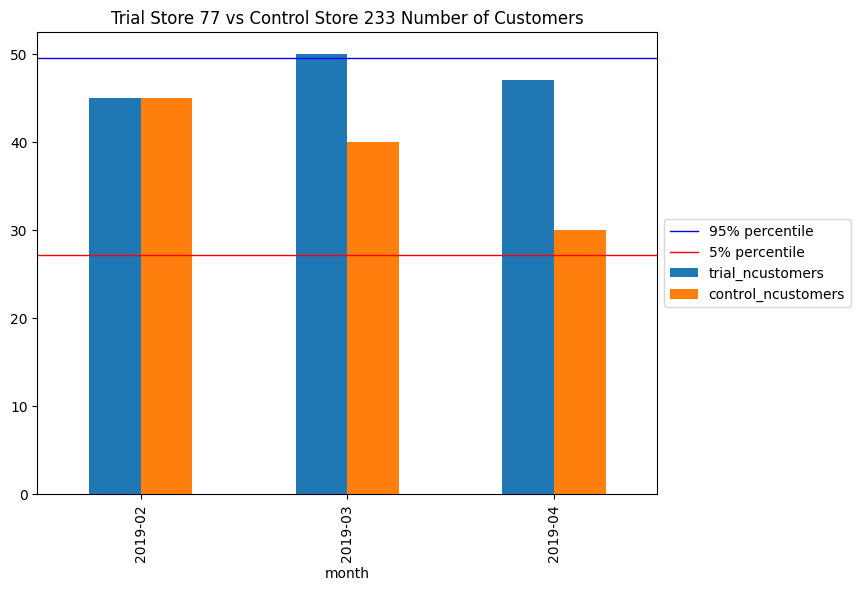

In [47]:
plt.rcParams['figure.figsize'] = (8, 6)

# plot trial store 77 and control store 233 customer number 
control = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 233].rename(columns={"number_customers": "control_ncustomers"})
trial = trial_full_observ[trial_full_observ['store_number'] == 77][['store_number', 'month', 'number_customers']].rename(columns={'number_customers': 'trial_ncustomers'})
trial_vs_control = trial[['month', 'trial_ncustomers']].merge(control[['month', 'control_ncustomers']], on='month').set_index('month')
trial_vs_control.plot.bar()

control_scaled_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 233]['number_customers']
std = scaled_ncust_control_stores_vs_trial[(scaled_ncust_control_stores_vs_trial['control_store'] == 233) & (scaled_ncust_control_stores_vs_trial['trial_period'] == 'pre')]['ncust_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_ncust.mean() + (control_scaled_ncust.mean() * std * 2)
percentile_5 = control_scaled_ncust.mean() - (control_scaled_ncust.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='95% percentile')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='5% percentile')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 77 vs Control Store 233 Number of Customers")
plt.show()



We can see that the trial store has a higher number of customers than the control store during the trial period, but it's still within the 95th percentile range of the control store's customer numbers. This suggests that the trial period did not have a significant impact on the number of customers.

Std: 0.07258281710386073, percentile_95: 109.93590088394126, percentile_5: 82.06409911605874 



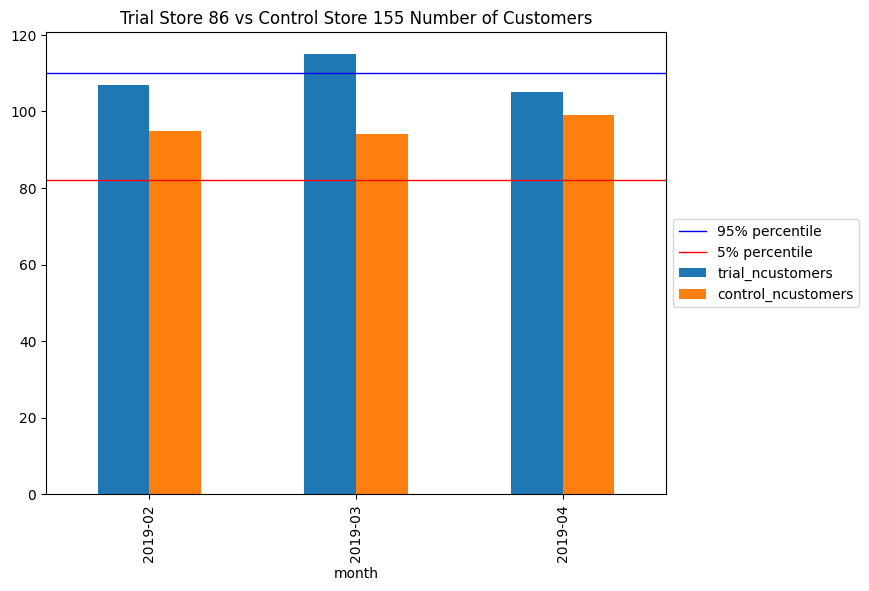

In [51]:
plt.rcParams['figure.figsize'] = (8, 6)

# plot trial store 86 and control store 155 customer number 
control = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 155].rename(columns={"number_customers": "control_ncustomers"})
trial = trial_full_observ[trial_full_observ['store_number'] == 86][['store_number', 'month', 'number_customers']].rename(columns={'number_customers': 'trial_ncustomers'})
trial_vs_control = trial[['month', 'trial_ncustomers']].merge(control[['month', 'control_ncustomers']], on='month').set_index('month')
trial_vs_control.plot.bar()

control_scaled_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 155]['number_customers']
std = scaled_ncust_control_stores_vs_trial[(scaled_ncust_control_stores_vs_trial['control_store'] == 155) & (scaled_ncust_control_stores_vs_trial['trial_period'] == 'pre')]['ncust_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_ncust.mean() + (control_scaled_ncust.mean() * std * 2)
percentile_5 = control_scaled_ncust.mean() - (control_scaled_ncust.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='95% percentile')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='5% percentile')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 86 vs Control Store 155 Number of Customers")
plt.show()




As you can see, the trial store's performance is aligned with the control store's performance before the trial period. During the trial period, the trial store's performance improved, and it was above the 95% confidence interval of the control store. Therefore, we can conclude that the trial was successful in this case.

Std: 0.0834927141781641, percentile_95: 141.9832271166866, percentile_5: 101.35010621664674 



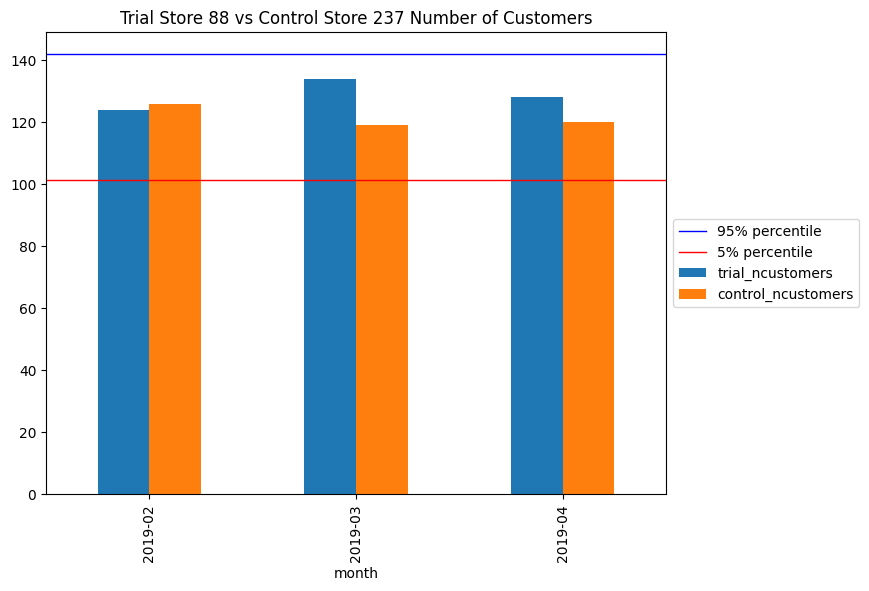

In [53]:
plt.rcParams['figure.figsize'] = (8, 6)

# plot trial store 88 and control store 237 customer number 
control = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 237].rename(columns={"number_customers": "control_ncustomers"})
trial = trial_full_observ[trial_full_observ['store_number'] == 88][['store_number', 'month', 'number_customers']].rename(columns={'number_customers': 'trial_ncustomers'})
trial_vs_control = trial[['month', 'trial_ncustomers']].merge(control[['month', 'control_ncustomers']], on='month').set_index('month')
trial_vs_control.plot.bar()

control_scaled_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores['store_number'] == 237]['number_customers']
std = scaled_ncust_control_stores_vs_trial[(scaled_ncust_control_stores_vs_trial['control_store'] == 237) & (scaled_ncust_control_stores_vs_trial['trial_period'] == 'pre')]['ncust_percentage_diff'].std()

# Control store 95th percentile and Control store 5th percentile
percentile_95 = control_scaled_ncust.mean() + (control_scaled_ncust.mean() * std * 2)
percentile_5 = control_scaled_ncust.mean() - (control_scaled_ncust.mean() * std * 2)
print(f"Std: {std}, percentile_95: {percentile_95}, percentile_5: {percentile_5} \n")

plt.axhline(y=percentile_95, linewidth=1, color='b', label='95% percentile')
plt.axhline(y=percentile_5, linewidth=1, color='r', label='5% percentile')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Trial Store 88 vs Control Store 237 Number of Customers")
plt.show()




it seems like the trial had a positive effect on the total number of customers in the trial store compared to the control stores. However, it's also important to note that the trial store's performance fell within the 5% to 95% confidence interval of the control store, which suggests that there may not be a significant difference in performance between the two stores.

## Conclusion
Based on the analysis, we have identified control stores 233, 155, and 237 as the best match for trial stores 77, 86, and 88, respectively.

We have compared the total sales and number of customers for the trial stores and their respective control stores during the trial period. For trial store 77, the total sales during the trial period were significantly higher than the control store, but there was no significant difference in the number of customers. For trial store 86, the number of customers during the trial period was significantly higher than the control store for two out of three months, indicating a positive trial effect. However, the trial store's performance lies within the 5% to 95% confidence interval of the control store. For trial store 88, the total number of customers during the trial period was significantly higher than the control store, indicating a positive trial effect.

Therefore, we can conclude that the trial stores have shown some positive effects during the trial period in terms of sales and customer numbers. However, it is also important to note that these effects were not consistent across all trial stores and that the trial store's performance lies within the 5% to 95% confidence interval of the control store in some cases.

we can prepare our presentation to the Category Manager.
